# Modelagem e Simulação - parte 3


```
(*) Adaptado de material preparado pelo Prof. Ronaldo Prati 
```

# Quem será o campeão? 

Uma das paixões no Brasil é o futebol. A cada campeonato, diversos especialistas analisam elencos, táticas, etc., para tentar prever quem será o campeão. Neste *notebook*, iremos construir um simulador simples para tentar prever as chances de cada time ser o campeão. 

A simulação usa o [ranqueamento global de clubles](https://projects.fivethirtyeight.com/global-club-soccer-rankings/), mantido pelo *site* de predições [fivethirdeight](https://fivethirtyeight.com/). Esse ranqueamento é atualizado frequentemente, e pode ser baixado nesse [link](https://data.fivethirtyeight.com/#soccer-spi). Nessa simulação, usaremos uma cópia baixada no dia 09 de novembro de 2020, e que pode ser vista [nesse endereço](https://drive.google.com/file/d/1XJpC_XY5Pf-AIhBvKrCQVyuUa_357MSf/view?usp=sharing).

Vamos carregar essa base usando o pandas. Além dela, vamos carregar algumas outras bibliotecas que usaremos:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm      ### necessária para barras de progressão
clubes = pd.read_csv("https://drive.google.com/u/3/uc?id=1XJpC_XY5Pf-AIhBvKrCQVyuUa_357MSf&export=download",index_col='name')

Analisando uma amostra dos dados, como mostrado na próxima célula, podemos observar que, para cada clue, ela contém o rank atual (`rank`), o rank do ano anterior (`prev_rank`), o nome do clube (`name`), o seu potencial ofensivo (`off`) e defensivo (`def`), e o potencial de pontuação (`spi`).



In [6]:
clubes.sample(10)

,rank,prev_rank,league,off,def,spi
name,,,,,,
AmaZulu,604,603,South African ABSA Premier League,0.31,1.68,13.48
Real Monarchs SLC,605,604,United Soccer League,0.56,2.22,13.33
Crawley Town,594,589,English League Two,0.55,2.05,15.00
Lorient,170,171,French Ligue 1,1.43,1.14,52.60
Corinthians,204,205,Brasileiro Série A,1.25,1.09,49.28
Austin Bold FC,544,544,United Soccer League,0.94,2.16,21.69
AC Milan,20,17,Italy Serie A,2.37,0.71,79.92
Lincoln City,534,527,English League One,0.72,1.76,22.48
Lyngby,523,525,Danish SAS-Ligaen,0.88,1.92,23.88


## Selecionando um clube

Podemos selecionar um clube específico usando o comando `.loc`, e colocando o nome do clube entre colchetes. Por exemplo, para selecionar o Barcelona, podemos fazer:

In [ ]:
clubes.loc['Barcelona']

rank                                3
prev_rank                           3
league       Spanish Primera Division
off                              3.01
def                               0.5
spi                             90.16
Name: Barcelona, dtype: object

## Potencial ofensivo e defensivo


A nossa simulação irá se basear no **potencial ofensivo** e **defensivo** de cada clube. 

Sobre potencial ofensivo temos que:
* é o número médio de gols que se espera que um clube marque enfrentanto um clube com potencial defensivo igual a 1. 
* Por exemplo, o valor de off=1,5 para um "clube A" indica que se ele jogar 10 partidas contra um "clube B" com def=1, espera-se que o "clube A" marque 15 gols em um campo neutro (marcará 1,5 gol em média). 

Sobre potencial defensivo temos que:
* é o número de gols que se espera que um clube sofra, enfrentando um clube com potencial ofensivo = 1.
* Por exemplo, o valor de def=1,5 de um "clube B" indica que se ele jogar 10 partidas contra um "clube A" com off=1, em um campo neutro, o "clube B" sofrerá 15 gols (sofrerá 1,5 gol em média).


A simulação do site [fivethirdeight](https://projects.fivethirtyeight.com/soccer-predictions/brasileirao/) é bem mais complexa, e contempla diversos fatores adicionais:
* se o time está jogando em seu estádio ou fora dele;
* a dificuldade do campenato;
* a incerteza a respeito do potencial ofensivo e defensivo
* a evolução desses potenciais ao longo do tempo. 

Além disso, ela é refeita com os resultados das partidas já disputadas, simulando o restante do campeonato. Mas as nossa simulação é uma boa aproximação. 

### Histograma - potencial ofensivo e defensivo
Os histogramas a seguir mostram a distribuição do potencial ofensivo e defensivo dos clubes presentes no ranqueamento:

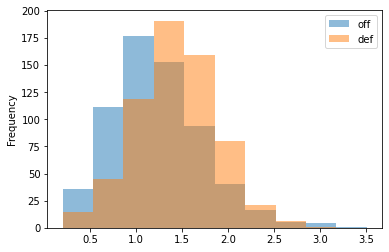

In [ ]:
clubes[['off','def']].plot(kind='hist',alpha=0.5)

### Campeonato Brasileiro
Vamos filtrar apenas os 20 clubes da Série A do Campeonato Brasileiro. 

In [7]:
brasileiro = clubes.query("league == 'Brasileiro Série A'")
brasileiro

,rank,prev_rank,league,off,def,spi
name,,,,,,
Flamengo,55,50,Brasileiro Série A,2.00,0.96,68.72
Grêmio,83,91,Brasileiro Série A,1.60,0.85,63.57
São Paulo,89,86,Brasileiro Série A,1.51,0.81,62.57
Palmeiras,100,116,Brasileiro Série A,1.56,0.92,60.88
Atletico Mineiro,105,100,Brasileiro Série A,1.69,1.04,60.65
Internacional,123,113,Brasileiro Série A,1.44,0.92,58.15
Santos,154,150,Brasileiro Série A,1.38,1.02,54.27
Atlético Paranaense,178,193,Brasileiro Série A,1.21,0.95,51.83
Fluminense,182,177,Brasileiro Série A,1.27,1.02,51.46


### Histograma - Campeonato Brasileiro

Os histogramas a seguir mostram a distribuição do potencial ofensivo e defensivo dos clubes presentes no campeonado brasileiro:

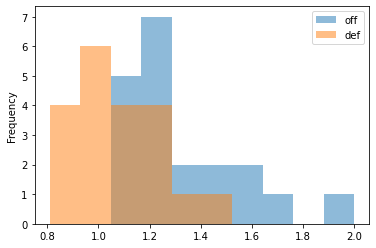

In [ ]:
brasileiro[['off','def']].plot(kind='hist',alpha=0.5)

# Simulando jogos

Para a simulação de jogos, vamos usar o **potencial ofensivo e denfensivo** dos clubes envolvidos em um jogo. 

Para simular o número de gols de cada equipe, vamos usar a [distribuição de Poisson](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_de_Poisson). Em linhas gerais, essa distribuição modela eventos aleatórios com uma taxa $\lambda$ conhecida. 

No caso de nossa simualação, usaremos duas distribuições de Poisson, sendo que cada uma delas é usada para simular o número de gols de cada time. Por exemplo, se os times $A$ e $B$ estão jogando, a taxa do time $A$ ($\lambda_A$)  será a multiplicação entre o potencial ofensivo do time $A$ e do potencial defensivo do time $B$, como mostrado na equação:

$$ \lambda_A = \text{off}_A \times \text{def}_B .$$

Já a taxa do time $B$ ($\lambda_B$)  será a razão entre o potencial ofensivo do time $B$ e do potencial defensivo do time $A$, como mostrado na equação:

$$ \lambda_B = \text{off}_B \times  \text{def}_A .$$




Dessa maneira, se um time $A$ com um potencial ofensivo de 2 enfrentar um time B com potencial defensivo 1,5, o valor de $\lambda_A = 3$, ou seja, espera-se que o time $A$ marque 3 gols em média por jogo contra o time $B$. Já se o time $B$ tem um potencial ofensivo de 2, mas o time $A$ tem um pontencial defensivo de 0,5, o valor de $\lambda_B = 1$, ou seja, espera-se que o time $B$ marque apenas um gol em média por jogo contra o time $A$. 


Em python, podemos usar a função `random.poisson` da biblioteca `numpy` para simular o número de gols de cada time. 

No trecho de código a seguir, simulamos o número de gols de 1000 partidas entre os times $A$ e $B$:
* time_A - off = 2.0 e def = 0.5
* time_B - off = 2.0 e def = 1.5

Note que "potencial defensivo" é "inversamente proporcional", ou seja, quanto menor o "potencial defensivo" do time "A",  menos gol  o "time B" irá marcar.

### Simulando 1 jogo (A X B)

In [8]:
off_A = 2
def_A = 0.5
off_B = 2
def_B = 1.5

lambda_A = off_A * def_B
print(lambda_A)
lambda_B = off_B * def_A
print(lambda_B)

gols_time_A = np.random.poisson(lambda_A,size=1000)
gols_time_B = np.random.poisson(lambda_B,size=1000)

3.0
1.0


Se calcularmos a média de gols de cada time, vemos que eles se aproximam do valor do seu respectivo valor de $\lambda$:

In [ ]:
print('Média de gols do time A:', gols_time_A.mean())
print('Média de gols do time B:', gols_time_B.mean())

Média de gols do time A: 3.04
Média de gols do time B: 0.98


Podemos também olhar a distribuição de gols dessas 1000 partidas construindo um hitograma:



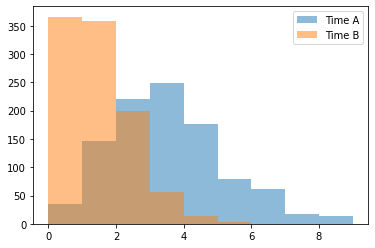

In [ ]:
plt.hist(gols_time_A,bins= list(range(10)),alpha=0.5,label="Time A")
plt.hist(gols_time_B,bins= list(range(10)),alpha=0.5,label="Time B")
plt.legend()
plt.show()

## Função - Partida

Vamos criar uma função que recebe dois times de nossa tabela e simula uma partida entre eles. Essa função calcula o valor de $\lambda_A$ e $\lambda_B$ a partir do potencial ofensivo e defensivo de cada time, simula uma partida, e retorna o número de gols de cada time.

In [9]:
def partida(timeA, timeB):

  lambdaA = timeA['off'] * timeB['def'] 
  lambdaB = timeB['off'] * timeA['def'] 

  gols = {}
  gols[timeA.name] = np.random.poisson(lambdaA)
  gols[timeB.name] = np.random.poisson(lambdaB)

  return(gols)
  

Como visto anteriormente, podemos selecionar um clube da tabela usando o comando `.loc`:

In [10]:
brasileiro.loc['Santos']

rank                        154
prev_rank                   150
league       Brasileiro Série A
off                        1.38
def                        1.02
spi                       54.27
Name: Santos, dtype: object

Podemos usar essa função para simular uma partida entre Santos e Corinthians, por exemplo:

In [15]:
partida(brasileiro.loc['Santos'],brasileiro.loc['Corinthians'])

{'Corinthians': 0, 'Santos': 3}

### Simulando 5000 jogos

O trecho abaixo simula 5 mil jogos entre os dois times.

A "barra de evolução" exibida é efeito da chamada à função `tqdm` (no for)

In [16]:
timeA = 'Santos'
timeB = 'Corinthians'
partidas = []
for i in tqdm(range(5000)):
  partidas.append(partida(brasileiro.loc[timeA],brasileiro.loc[timeB]))

df_partidas = pd.DataFrame(partidas)


  0%|          | 0/5000 [00:00<?, ?it/s]

E estimar a probabilidade de vitória de cada time a partir dessa simulação com base no número de vitórias, empates e derrotas:

In [ ]:
# time A marcou mais gols que time B
print("Probabilidade Vitória ", timeA, "%.2f" % ((df_partidas[timeA] > df_partidas[timeB]).mean()*100))

# time B marcou mais gols que time A
print("Probabilidade Vitória ", timeB, " %.2f" %((df_partidas[timeA] < df_partidas[timeB]).mean()*100))

#dois times marcaram o mesmo número de gols
print("Probabilidade Empate %.2f" %((df_partidas[timeA] == df_partidas[timeB]).mean()*100))

Probabilidade Vitória  Santos 42.40
Probabilidade Vitória  Corinthians  32.60
Probabilidade Empate 25.00


## **Exercícios:** 

1. O time que joga fora do seu estádio (o "visitante"), em geral, tem um potencial menor que o time que joga em seu estádio (o "mandante"). Considerando que o time $A$ é o mandante e o time $B$ é o visitante, crie uma versão da função partida em que o valor de $\lambda$ tem uma redução de 20% para o time visitante.

2. Crie uma versão do simulador de partida que só considera o potencial ofensivo no cálculo de $\lambda$. 

# Extra


## Simulando campeonatos

Vamos simular agora um campeonato em que todos os times jogam contra todos os outros times duas vezes (campeonato de pontos corridos). Como você deve saber, o vencedor da partida ganha 3 pontos. Em caso de empate, cada time ganha um ponto. 

Inicialmente vamos criar uma banco de dados para armazer a tabela do campeonato. Nessa tabela, vamos armazenar:

- total de **pontos** que o time conquistou no campeonato
- número de **vitórias** que o time obteve no campeonato
- numero de **empates** que o time obteve no campeonato
- número de **derrotas** que o time obteve no campeonato
- número de **gols marcados** por cada time no campeonato
- número de **gols sofridos** por cada time no campeonato
- diferença entre gols marcados e gols sofridos (**saldo de gols**) 

In [ ]:
# cria a tabela
tabela = pd.DataFrame(index=brasileiro.index,columns=["pontos", "vitórias", "empates", "derrotas", "gols marcados", "gols sofridos", "saldo de gols"])

# incializa os valores com zero
tabela.fillna(0,inplace=True)

# mostra a tabela
tabela

,pontos,vitórias,empates,derrotas,gols marcados,gols sofridos,saldo de gols
name,,,,,,,
Flamengo,0,0,0,0,0,0,0
Grêmio,0,0,0,0,0,0,0
São Paulo,0,0,0,0,0,0,0
Palmeiras,0,0,0,0,0,0,0
Atletico Mineiro,0,0,0,0,0,0,0
Internacional,0,0,0,0,0,0,0
Santos,0,0,0,0,0,0,0
Atlético Paranaense,0,0,0,0,0,0,0
Fluminense,0,0,0,0,0,0,0


Agora vamos simular os jogos. Uma maneira de fazer com que todos os times joguem contra todos os outros times é usar um *laço duplo*, em que simulamos um jogo, e atualizamos a tabela:

In [ ]:
for timeA in brasileiro.index:
  for timeB in brasileiro.index:

    if timeA == timeB: # o time não joga contra ele mesmo
      pass 
    else:
      # simula uma partido entre os times
      resultado = partida(brasileiro.loc[timeA],brasileiro.loc[timeB])

      # atualiza o número de gols marcados, sofridos e saldo
      tabela.loc[timeA,'gols marcados'] += resultado[timeA]
      tabela.loc[timeB,'gols marcados'] += resultado[timeB]

      tabela.loc[timeA,'gols sofridos'] += resultado[timeB]
      tabela.loc[timeB,'gols sofridos'] += resultado[timeA]

      tabela.loc[timeA,'saldo de gols'] += resultado[timeA] - resultado[timeB] 
      tabela.loc[timeB,'saldo de gols'] += resultado[timeB] - resultado[timeA]

      # finalmente, atualizamos os pontos e número de vitórias, empates e derrotas
      if resultado[timeA] > resultado[timeB]: # time A ganhou
        tabela.loc[timeA,'pontos'] += 3  
        tabela.loc[timeA,'vitórias'] += 1
        tabela.loc[timeB,'derrotas'] += 1
      elif resultado[timeA] < resultado[timeB]: # time B ganhou
        tabela.loc[timeB,'pontos'] += 3  
        tabela.loc[timeB,'vitórias'] += 1
        tabela.loc[timeA,'derrotas'] += 1;
      else: # os times empataram
        tabela.loc[timeA,'pontos'] += 1
        tabela.loc[timeB,'pontos'] += 1
        tabela.loc[timeA,'empates'] += 1;
        tabela.loc[timeB,'empates'] += 1;

Podemos ver o resultado da simulação, ordenando pelo número de pontos, número de vitórias, saldo de gols e número de gols marcados:

In [20]:
tabela = pd.DataFrame(index=brasileiro.index,columns=["pontos", "vitórias", "empates", "derrotas", "gols marcados", "gols sofridos", "saldo de gols"])
tabela.fillna(0,inplace=True)
tabela.sort_values(['pontos','vitórias','saldo de gols','gols marcados'],ascending=False, inplace=True)
for timeA in brasileiro.index:
  for timeB in brasileiro.index:

    if timeA == timeB: # o time não joga contra ele mesmo
      pass 
    else:
      # simula uma partido entre os times
      resultado = partida(brasileiro.loc[timeA],brasileiro.loc[timeB])

      # atualiza o número de gols marcados, sofridos e saldo
      tabela.loc[timeA,'gols marcados'] += resultado[timeA]
      tabela.loc[timeB,'gols marcados'] += resultado[timeB]

      tabela.loc[timeA,'gols sofridos'] += resultado[timeB]
      tabela.loc[timeB,'gols sofridos'] += resultado[timeA]

      tabela.loc[timeA,'saldo de gols'] += resultado[timeA] - resultado[timeB] 
      tabela.loc[timeB,'saldo de gols'] += resultado[timeB] - resultado[timeA]

      # finalmente, atualizamos os pontos e número de vitórias, empates e derrotas
      if resultado[timeA] > resultado[timeB]: # time A ganhou
        tabela.loc[timeA,'pontos'] += 3  
        tabela.loc[timeA,'vitórias'] += 1
        tabela.loc[timeB,'derrotas'] += 1
      elif resultado[timeA] < resultado[timeB]: # time B ganhou
        tabela.loc[timeB,'pontos'] += 3  
        tabela.loc[timeB,'vitórias'] += 1
        tabela.loc[timeA,'derrotas'] += 1;
      else: # os times empataram
        tabela.loc[timeA,'pontos'] += 1
        tabela.loc[timeB,'pontos'] += 1
        tabela.loc[timeA,'empates'] += 1;
        tabela.loc[timeB,'empates'] += 1;
tabela

,pontos,vitórias,empates,derrotas,gols marcados,gols sofridos,saldo de gols
name,,,,,,,
Flamengo,85,26,7,5,80,35,45
Grêmio,70,21,7,10,79,40,39
São Paulo,73,21,10,7,63,44,19
Palmeiras,54,14,12,12,47,46,1
Atletico Mineiro,53,15,8,15,63,61,2
Internacional,54,14,12,12,59,49,10
Santos,54,16,6,16,47,51,-4
Atlético Paranaense,63,17,12,9,58,45,13
Fluminense,61,17,10,11,53,49,4


Finalmente, vamos construir um dicionário que armazena a classificação final de cada time:

In [22]:
classificacao = dict(zip(tabela.index, range(1,20)))
classificacao

{'Atletico Mineiro': 5,
 'Atlético Goianiense': 16,
 'Atlético Paranaense': 8,
 'Bahía': 10,
 'Botafogo': 15,
 'Bragantino': 12,
 'Ceará': 13,
 'Corinthians': 11,
 'Coritiba': 18,
 'Flamengo': 1,
 'Fluminense': 9,
 'Fortaleza': 14,
 'Grêmio': 2,
 'Internacional': 6,
 'Palmeiras': 4,
 'Santos': 7,
 'Sport Recife': 19,
 'São Paulo': 3,
 'Vasco da Gama': 17}

### Exercícios:

1. Calcule a correlação entre o potencial ofensivo de cada time e o número de gols marcados em uma simulação. O que você pode dizer a respeito dessa correlação?

2. Calcule a correlação entre o potencial defensivo de cada time e o número de gols marcados em uma simulação. O que você pode dizer a respeito dessa correlação?

3. Calcule a correlação entre o número de pontos de uma simulação e o o seu `spi`. O que você pode dizer a respeito dessa correlação? 


## Campeonato

Vamos criar uma função que simula o campeonato. Essa função recebe uma lista de times e seus respectivos potenciais ofensivos e defensivos, e devolve a classificação final de cada time, usando os elementos descritos anteriormente.

In [ ]:
def campeonato(times):
  # observe que agora usamos o parâmetro times
  tabela = pd.DataFrame(index=times.index,columns=["pontos", "vitórias", "empates", "derrotas", "gols marcados", "gols sofridos", "saldo de gols"])
  tabela.fillna(0,inplace=True)

  for timeA in times.index:
    for timeB in times.index:

      if timeA == timeB: # o time não joga contra ele mesmo
        pass 
      else:
        # simula uma partido entre os times
        resultado = partida(times.loc[timeA],times.loc[timeB])

        # atualiza o número de gols marcados, sofridos e saldo
        tabela.loc[timeA,'gols marcados'] += resultado[timeA]
        tabela.loc[timeB,'gols marcados'] += resultado[timeB]

        tabela.loc[timeA,'gols sofridos'] += resultado[timeB]
        tabela.loc[timeB,'gols sofridos'] += resultado[timeA]

        tabela.loc[timeA,'saldo de gols'] += resultado[timeA] - resultado[timeB] 
        tabela.loc[timeB,'saldo de gols'] += resultado[timeB] - resultado[timeA]

        # finalmente, atualizamos os pontos e número de vitórias, empates e derrotas
        if resultado[timeA] > resultado[timeB]: # time A ganhou
          tabela.loc[timeA,'pontos'] += 3  
          tabela.loc[timeA,'vitórias'] += 1
          tabela.loc[timeB,'derrotas'] += 1
        elif resultado[timeA] < resultado[timeB]: # time B ganhou
          tabela.loc[timeB,'pontos'] += 3  
          tabela.loc[timeB,'vitórias'] += 1
          tabela.loc[timeA,'derrotas'] += 1;
        else: # os times empataram
          tabela.loc[timeA,'pontos'] += 1
          tabela.loc[timeB,'pontos'] += 1
          tabela.loc[timeA,'empates'] += 1;
          tabela.loc[timeB,'empates'] += 1;

  tabela.sort_values(['pontos','vitórias','saldo de gols','gols marcados'],ascending=False, inplace=True)
  classificacao = dict(zip(tabela.index, range(1,21)))
  return classificacao


Podemos usar essa função para simular todo o campeonato. Observe que a simulação pode variar se executarmos mais de uma vez:


In [ ]:
campeonato(brasileiro)

{'Atletico Mineiro': 6,
 'Atlético Goianiense': 18,
 'Atlético Paranaense': 13,
 'Bahía': 12,
 'Botafogo': 9,
 'Bragantino': 8,
 'Ceará': 14,
 'Corinthians': 15,
 'Coritiba': 19,
 'Flamengo': 3,
 'Fluminense': 5,
 'Fortaleza': 20,
 'Goiás': 17,
 'Grêmio': 4,
 'Internacional': 7,
 'Palmeiras': 1,
 'Santos': 10,
 'Sport Recife': 11,
 'São Paulo': 2,
 'Vasco da Gama': 16}

## Exercícios:

1. Crie uma versão de campeonado que usa a função de simulação de partida que você criou anteriormente, e que reduz o $\lambda$ do time mantante em 20\%.

1. Crie uma versão de campeonato que usa s função  de simulação de partida que você criou anteriormente, e que só considera o pontecial ofensivo.

1. Faça uma simulação de campeonato para as ligas:
  - German Bundesliga (Campeonato Alemão)
  - Barclays Premier League (Campeonato Inglês)
  - Spanish Primera Division (Campeonato Espanhol)
  - Italy Serie A (Campeonato Italiano)

1. Simule o campeonato Brasileiro com o simulador que você criou nos exercícios 1 e 2.

## Probabilidade de ser campeão

Agora vamos usar a função que criamos para simular um grande número de campeonatos, e a partir dessa simulação calcular a probabilidade de cada time ser o campeão, de acordo com o nosso modelo. 

Inicialmente, criamos uma tabele vazia em que cada coluna é um time:

In [ ]:
simulacao = pd.DataFrame(columns=list(brasileiro.index))

Agora, vamos adicionar linhas a essa tabela, em que cada linha é uma simulação. O trecho de código a seguir faz popula a base com 500 simulações. Uma vez que a simulação pode demorar, a função `tqdm` cria automaticamente uma barra de progresso.

In [ ]:
for i in tqdm(range(500)):
  simulacao.loc[i] = campeonato(brasileiro)

Essa tabela de simualação vai armazenar a posição de cada clube em cada uma das simulação realizadas, como pode ser visto a seguir:

In [ ]:
simulacao

,Flamengo,Grêmio,São Paulo,Palmeiras,Atletico Mineiro,Internacional,Santos,Atlético Paranaense,Fluminense,Bahía,Corinthians,Bragantino,Ceará,Fortaleza,Botafogo,Atlético Goianiense,Vasco da Gama,Coritiba,Sport Recife,Goiás
0,2,1,5,6,11,10,8,3,7,4,16,12,15,9,14,20,17,19,13,18
1,3,2,1,7,6,4,5,10,9,12,18,15,11,13,8,14,17,16,19,20
2,1,3,2,9,7,6,18,12,14,8,13,10,5,16,4,17,20,15,19,11
3,1,10,6,3,5,4,2,16,15,11,9,8,7,20,12,13,18,17,19,14
4,1,2,4,3,7,5,6,8,12,9,16,11,10,13,15,17,14,19,18,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3,5,1,4,2,13,6,12,11,17,7,9,10,16,8,20,18,14,15,19
496,3,9,2,1,6,8,4,7,12,10,5,11,17,15,16,19,20,13,18,14
497,3,5,2,1,10,4,11,6,14,12,8,13,7,9,15,19,17,20,18,16
498,2,1,4,5,10,3,7,8,12,9,6,15,18,14,13,11,19,17,20,16


Podemos visualizar os resultados dessas simualações criando histogramas, que nos dá uma ideia da probabilidade dos times terminem em cada colocação:

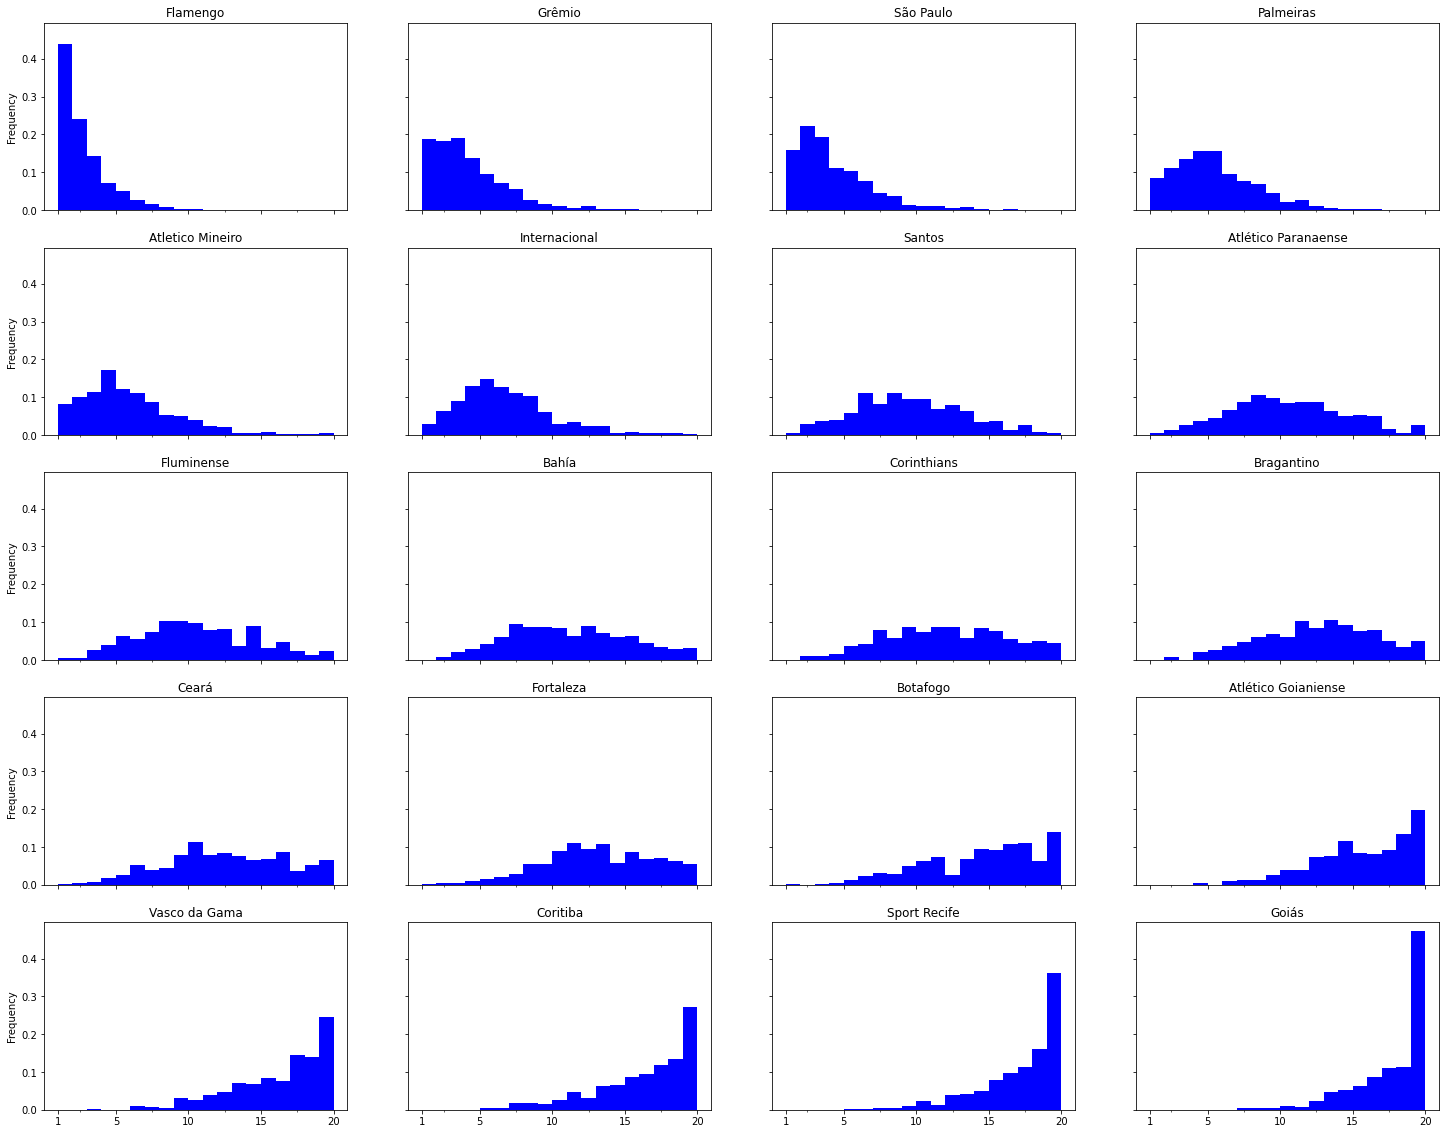

In [ ]:
g = simulacao.plot(kind='hist',subplots=True,layout=(5,4),density=True,bins=list(range(1,21)),color='blue',xticks=[1,5,10,15,20],
               legend=False,figsize=(25,20),title=list(simulacao.columns),sharey=True)

Além disso, podemos calcular, para cada posição específica, a probabilidade de cada time ficar naquela posição. Para isso, calculamos a frequencia relativa da posição de cada time, e armazenamos em uma tabela.

In [ ]:
posicoes = simulacao.apply(pd.Series.value_counts)/simulacao.shape[0]
posicoes = posicoes.fillna(0)
posicoes = posicoes.T
posicoes

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Flamengo,0.438,0.242,0.142,0.072,0.050,0.026,0.016,0.008,0.004,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Grêmio,0.188,0.182,0.190,0.138,0.094,0.072,0.056,0.026,0.016,0.010,0.006,0.012,0.004,0.004,0.002,0.000,0.000,0.000,0.000,0.000
São Paulo,0.158,0.222,0.192,0.112,0.102,0.078,0.046,0.036,0.014,0.012,0.010,0.006,0.008,0.002,0.000,0.002,0.000,0.000,0.000,0.000
Palmeiras,0.084,0.112,0.134,0.156,0.156,0.094,0.076,0.068,0.046,0.022,0.026,0.010,0.006,0.002,0.004,0.004,0.000,0.000,0.000,0.000
Atletico Mineiro,0.082,0.100,0.114,0.172,0.122,0.110,0.086,0.052,0.050,0.040,0.024,0.020,0.006,0.004,0.008,0.002,0.002,0.002,0.004,0.000
Internacional,0.028,0.064,0.090,0.130,0.148,0.126,0.110,0.104,0.060,0.030,0.034,0.024,0.024,0.006,0.008,0.004,0.004,0.004,0.000,0.002
Santos,0.006,0.028,0.038,0.040,0.058,0.110,0.082,0.112,0.096,0.094,0.070,0.078,0.064,0.034,0.036,0.014,0.026,0.008,0.004,0.002
Atlético Paranaense,0.004,0.012,0.026,0.038,0.044,0.066,0.086,0.106,0.098,0.084,0.086,0.088,0.064,0.050,0.052,0.050,0.016,0.004,0.016,0.010
Fluminense,0.006,0.004,0.026,0.040,0.062,0.054,0.074,0.104,0.102,0.098,0.080,0.082,0.038,0.090,0.032,0.048,0.024,0.012,0.014,0.010
Bahía,0.000,0.008,0.020,0.030,0.042,0.060,0.094,0.088,0.088,0.084,0.064,0.090,0.070,0.060,0.064,0.044,0.034,0.028,0.026,0.006


Podemos construir um gráfico de barras para cada posição:

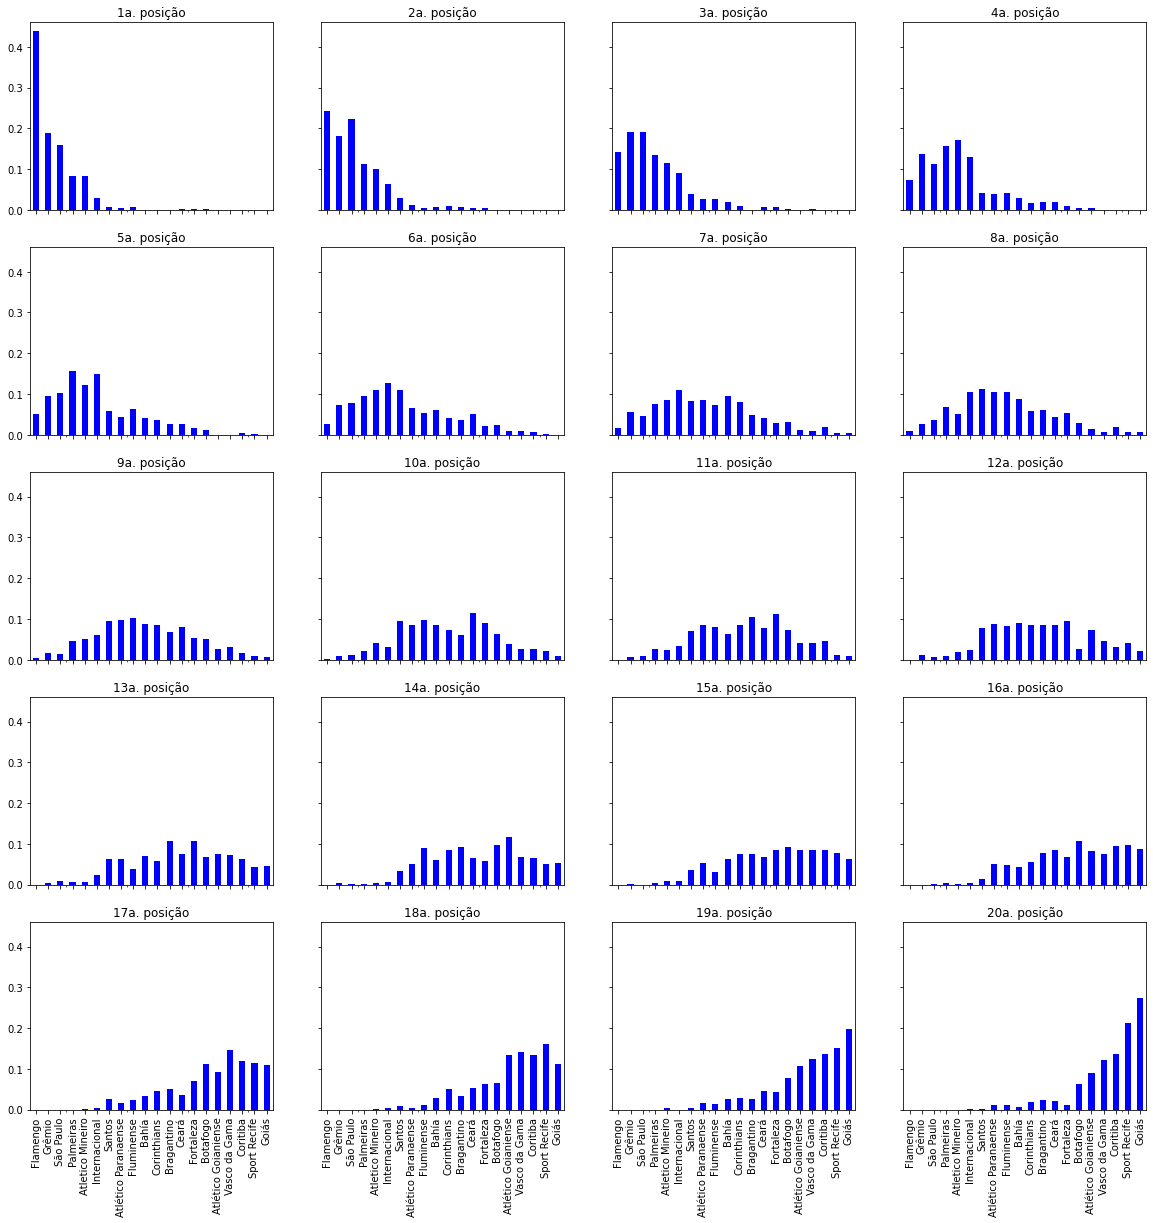

In [ ]:
nomes = [str(i)+'a. posição' for i in range(1,21)]
g = posicoes.plot(kind='bar',subplots=True,layout=(5,4),legend=False,
                    sharey=True,color='b',figsize=(20,20),title=nomes)

## Exercícios:

1. Crie uma função que, a partir da tabela de posições, calcule a probabilidade de um time ficar nas 5 primeiras posições.

1. Crie uma função que, a partir da tabela de posições, cacule a probabibilidade de um time ficar nas 4 últimas posições. 